## classifier method search

premise: use a looped grid search to explore the accuracy metrics of classfiers

In [3]:
!pip3 install shap
!pip3 install seaborn

     |████████████████████████████████| 294 kB 1.7 MB/s eta 0:00:01


In [4]:
# import category_encoders as ce
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, RandomForestClassifier, \
ExtraTreesClassifier, RandomTreesEmbedding, BaggingClassifier
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from scipy import stats

from sklearn.tree import DecisionTreeClassifier
import shap
import pandas as pd
import time
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt


In [6]:
m2_pipeline = pd.read_csv('binary_binned_pipeline.csv')


## testing data for colinearity among features

In [7]:
m2_pipeline.corr(numeric_only=True)

,Unnamed: 0,precursor_buy_cap_pct_change,precursor_ask_cap_pct_change,precursor_bid_vol_pct_change,precursor_ask_vol_pct_change,sum_change,length,surge_targets_met_pct,time,label
Unnamed: 0,1.000000,-0.072097,-0.044220,-0.079542,-0.002249,0.027246,0.061405,0.009566,0.997808,-0.027631
precursor_buy_cap_pct_change,-0.072097,1.000000,0.176897,0.829986,0.178041,0.123180,-0.064895,0.047555,-0.076319,0.028245
precursor_ask_cap_pct_change,-0.044220,0.176897,1.000000,0.284965,0.214040,-0.131156,0.028824,0.092484,-0.042819,0.057295
precursor_bid_vol_pct_change,-0.079542,0.829986,0.284965,1.000000,0.092731,0.014314,-0.003254,0.044184,-0.081366,0.030526
precursor_ask_vol_pct_change,-0.002249,0.178041,0.214040,0.092731,1.000000,-0.018833,-0.004819,-0.004618,-0.001997,-0.002048
sum_change,0.027246,0.123180,-0.131156,0.014314,-0.018833,1.000000,-0.247413,-0.094531,0.027195,-0.142211
length,0.061405,-0.064895,0.028824,-0.003254,-0.004819,-0.247413,1.000000,0.044550,0.061619,-0.004904
surge_targets_met_pct,0.009566,0.047555,0.092484,0.044184,-0.004618,-0.094531,0.044550,1.000000,0.008752,0.502314
time,0.997808,-0.076319,-0.042819,-0.081366,-0.001997,0.027195,0.061619,0.008752,1.000000,-0.027802
label,-0.027631,0.028245,0.057295,0.030526,-0.002048,-0.142211,-0.004904,0.502314,-0.027802,1.000000


<Axes: >

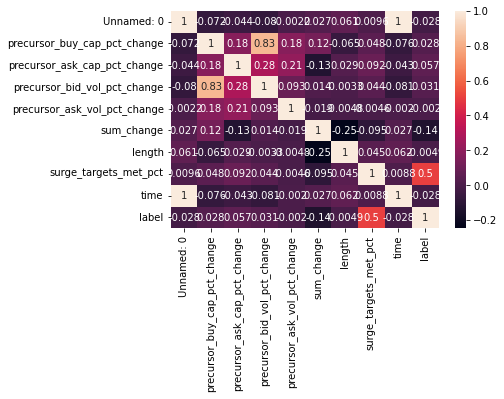

In [8]:
import pandas as pd
import seaborn as sns

# Load the dataset into a pandas dataframe

# Calculate the correlation matrix
corr_matrix = m2_pipeline.corr(numeric_only=True)

# Plot the correlation matrix
sns.heatmap(corr_matrix, annot=True)


XGB, GBM, CAT, FASTAI, NN_TORCH, LR, RF, XT

In [9]:
m2_pipeline.dtypes

Unnamed: 0                        int64
precursor_buy_cap_pct_change    float64
precursor_ask_cap_pct_change    float64
precursor_bid_vol_pct_change    float64
precursor_ask_vol_pct_change    float64
sum_change                      float64
length                            int64
surge_targets_met_pct           float64
time                            float64
label                             int64
dtype: object

### utilize the same feature composition as used in step 2

clustering setup, per 'step 2'

set m2_pipeline features to the set, below to do a classifier search

In [10]:
keepable = ['precursor_buy_cap_pct_change', 
            'precursor_ask_cap_pct_change',
            'precursor_bid_vol_pct_change', 
            'precursor_ask_vol_pct_change',
            'sum_change','length','time']

In [11]:

# Splitting the dataframe into features and labels
# X = m2_pipeline.drop(columns=['label'])
y = m2_pipeline['label'].values #per https://stackoverflow.com/a/73095562/12001832
X = m2_pipeline[keepable].values
# Performing the test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#normalize all numeric columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# Define the classifiers and their respective hyperparameters
classifiers = [
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    HistGradientBoostingClassifier(),
    ExtraTreesClassifier(),
    BaggingClassifier(),
    RidgeCV(),
    LassoCV(),
    SVC()
]

params = {
    'RandomForestClassifier': {'n_estimators': [10, 100, 1000], 'max_depth': [None, 10, 100]},
    'GradientBoostingClassifier': {'n_estimators': [10, 100, 1000], 'max_depth': [None, 10, 100]},
    'HistGradientBoostingClassifier': {'learning_rate': [0.1, 0.01], 'max_iter': [100, 200]},
    'ExtraTreesClassifier':{'n_estimators': [10, 100, 1000], 'max_depth': [None, 10, 100]},
    'BaggingClassifier':{ 'n_estimators':[10],  'random_state':[42]},
    'RidgeCV':{'alphas':[0.1, 1.0, 10.0]},
    'LassoCV':{ 'eps':[0.001, 0.01, .1], 'n_alphas':[100,200],  'max_iter':[100,200,300,1000]},
    'SVC':{'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
}
comparative = []
# Perform the grid search
for clf in classifiers:
    name = clf.__class__.__name__
    if name in params:
        grid_search = GridSearchCV(clf, params[name], cv=5)
        grid_search.fit(X_train_scaled, y_train)
        
        print(f"Best parameters for {name}: {grid_search.best_params_}")
        accuracy = grid_search.score(X_test, y_test)
        
        dict = {"classifier":name, "best_params":grid_search.best_params_, "accuracy":accuracy}
        comparative.append(dict)
dg = pd.DataFrame(comparative) #display grid

KeyboardInterrupt: 

In [48]:
dg

,classifier,best_params,accuracy
0,SVC,"{'C': 0.1, 'kernel': 'rbf'}",0.43825


In [141]:
rfc = RandomForestClassifier(max_depth=10, n_estimators=100,random_state= 42)
gbc = GradientBoostingClassifier(max_depth= 10, n_estimators= 10,random_state= 42)
hgbc = HistGradientBoostingClassifier(learning_rate= 0.01, max_iter= 100,random_state= 42)
etc = ExtraTreesClassifier(max_depth= 10, n_estimators= 1000,random_state= 42)
bc = BaggingClassifier(n_estimators= 10, random_state= 42)
svc = SVC(C=0.1, kernel='rbf')
treeGroup = [rfc, etc, gbc, hgbc] #tree based classifiers, for feature importance

## Voting Classifier

In [142]:
import shap #this library would take 30 hours to explain the above model, not to be used. would function on one tree, better
from sklearn.ensemble import  VotingClassifier 
from sklearn.model_selection import cross_val_score
X = m2_pipeline[keepable].values  #.drop(columns=['label']).values #per https://stackoverflow.com/a/73095562/12001832
y = m2_pipeline['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#normalize all numeric columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Define VotingClassifier 
weights = [0.1, 0.5, 0.1, 0.1, 0.2]
vc = VotingClassifier(estimators=[('rfc',rfc),('gbc',gbc),('hgbc',hgbc),('etc',etc),('bc',bc)], voting='hard', weights=weights) 
rfc.fit(X_train_scaled,y_train)
gbc.fit(X_train_scaled,y_train)
hgbc.fit(X_train_scaled,y_train)
etc.fit(X_train_scaled,y_train)
bc.fit(X_train_scaled,y_train)
svc.fit(X_train_scaled,y_train)
vc.fit(X_train_scaled,y_train)

# #fit all, voting classifier scoring
for clf, label in zip([rfc,gbc,hgbc,etc,bc,svc,vc], ['RandomForestClassifier', 'GradientBoostingClassifier', 'HistGradientBoostingClassifier', 'ExtraTreesClassifier',\
                                                    'BaggingClassifier','SVC','Voting']):
    scores = cross_val_score(clf, X_train_scaled, y_train, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.42 (+/- 0.01) [RandomForestClassifier]
Accuracy: 0.39 (+/- 0.01) [GradientBoostingClassifier]
Accuracy: 0.42 (+/- 0.01) [HistGradientBoostingClassifier]
Accuracy: 0.42 (+/- 0.00) [ExtraTreesClassifier]
Accuracy: 0.36 (+/- 0.01) [BaggingClassifier]
Accuracy: 0.42 (+/- 0.00) [SVC]
Accuracy: 0.40 (+/- 0.01) [Voting]


### feature importance based on feature permutation
[via scikit learn's rendition](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#feature-importance-based-on-feature-permutation)

Index(['Unnamed: 0', 'precursor_buy_cap_pct_change',
       'precursor_ask_cap_pct_change', 'precursor_bid_vol_pct_change',
       'precursor_ask_vol_pct_change', 'sum_change', 'length',
       'surge_targets_met_pct', 'time', 'label'],
      dtype='object') 7
RandomForestClassifier(max_depth=10, random_state=42)
Elapsed time to compute the importances: 1.276 seconds
RandomForestClassifier(max_depth=10, random_state=42)


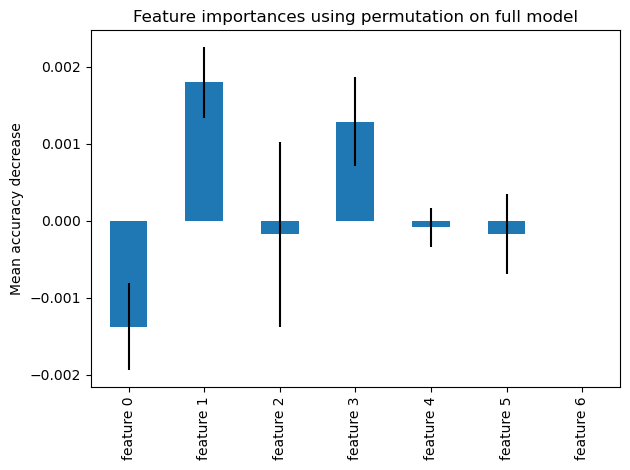

ExtraTreesClassifier(max_depth=10, n_estimators=1000, random_state=42)
Elapsed time to compute the importances: 3.414 seconds
ExtraTreesClassifier(max_depth=10, n_estimators=1000, random_state=42)


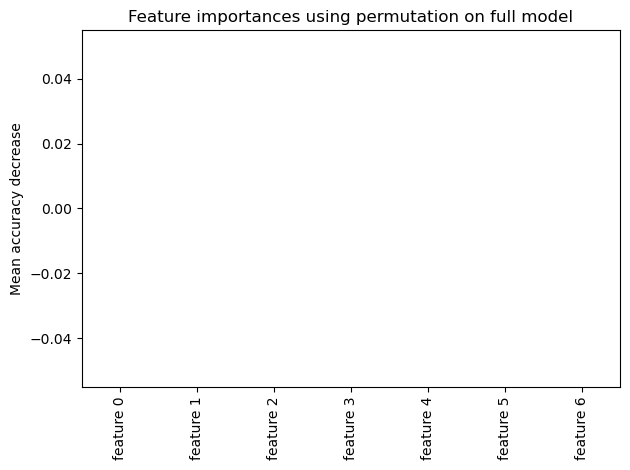

GradientBoostingClassifier(max_depth=10, n_estimators=10, random_state=42)
Elapsed time to compute the importances: 0.255 seconds
GradientBoostingClassifier(max_depth=10, n_estimators=10, random_state=42)


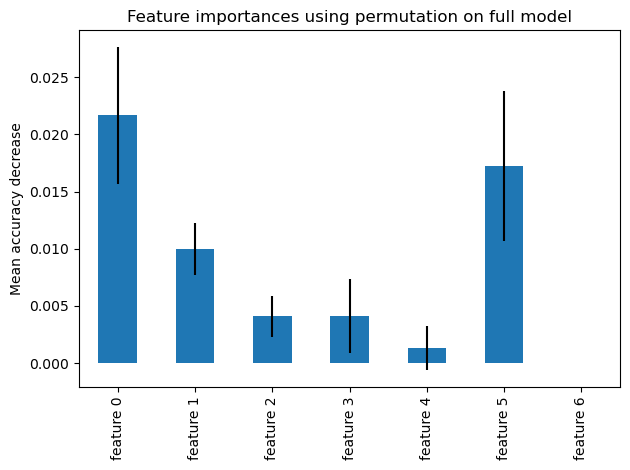

HistGradientBoostingClassifier(learning_rate=0.01, random_state=42)
Elapsed time to compute the importances: 2.488 seconds
HistGradientBoostingClassifier(learning_rate=0.01, random_state=42)


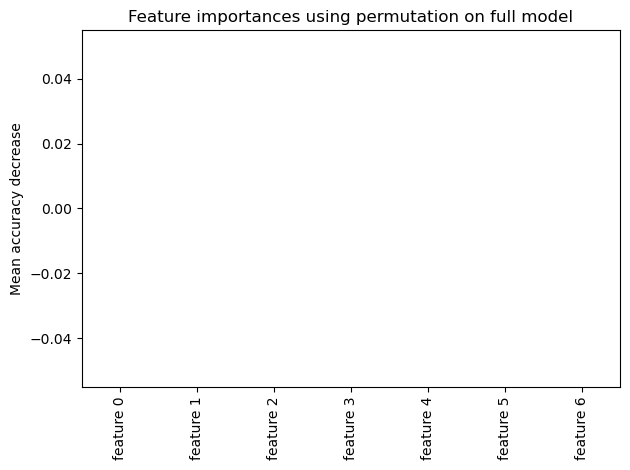

In [143]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]

print(m2_pipeline.columns,X.shape[1])
for i in range(len(treeGroup)):
    print(treeGroup[i]) #tree to study
    forest = treeGroup[i]
    start_time = time.time()
    result = permutation_importance(forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

    forest_importances = pd.Series(result.importances_mean, index=feature_names)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
    ax.set_title("Feature importances using permutation on full model")
    ax.set_ylabel("Mean accuracy decrease")
    fig.tight_layout()
    print(treeGroup[i]) #tree to study

    plt.show()

## Error Analysis

confusion matrix for multiclass predict vs true results. [source](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html)

In [144]:
labels_ = m2_pipeline['label'].unique()
print(labels_)

[ 4  5  6  7  3  2  9 10  1  8 11]


## voting classifier error analysis

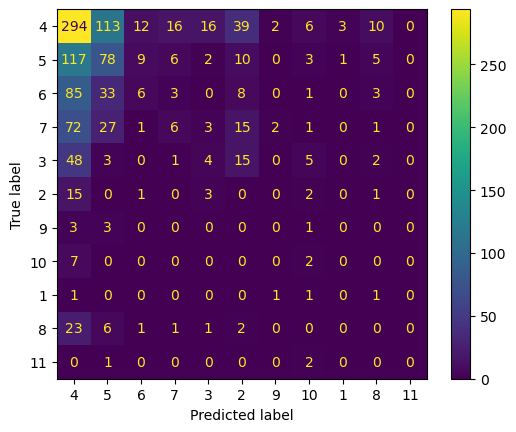

In [145]:
X_test_scaled = scaler.fit_transform(X_test)
y_pred = vc.predict(X_test_scaled)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=labels_)

error report courtesty of sklearn's [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn-metrics-classification-report)

In [146]:
print(classification_report(y_test, y_pred,zero_division=1))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        22
           3       0.14      0.05      0.07        78
           4       0.44      0.58      0.50       511
           5       0.30      0.34      0.32       231
           6       0.20      0.04      0.07       139
           7       0.18      0.05      0.07       128
           8       0.00      0.00      0.00        34
           9       0.00      0.00      0.00         7
          10       0.08      0.22      0.12         9
          11       1.00      0.00      0.00         3

    accuracy                           0.33      1166
   macro avg       0.21      0.12      0.11      1166
weighted avg       0.31      0.33      0.30      1166



uncertainty in prediction, per class basis, [per sklearn](https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_digits.html#plot-the-most-uncertain-predictions)

## SHAP feature analysis

[source](https://github.com/shap/shap)

In [148]:
keepable = ['precursor_buy_cap_pct_change', 
            'precursor_ask_cap_pct_change',
            'precursor_bid_vol_pct_change', 
            'precursor_ask_vol_pct_change',
            'sum_change',
            'length','time']

### Random Forest Classifier Feature Strength

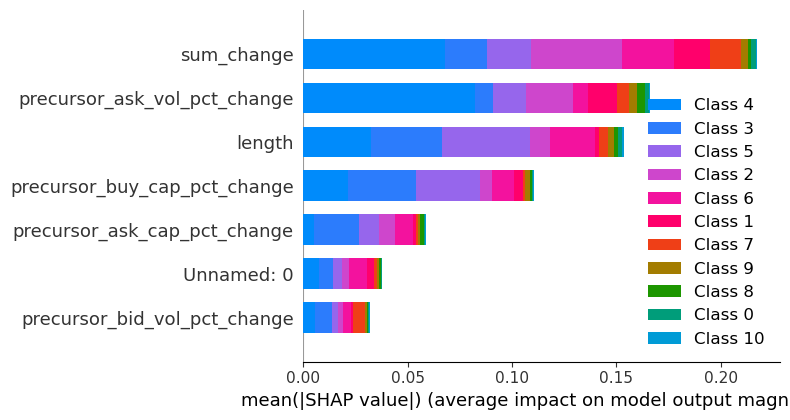

In [149]:
# estimators = [rfc,gbc,hgbc,etc,bc,vc]
model = rfc.fit(X_train_scaled,y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, features=m2_pipeline.columns)

### HGBC SHAP

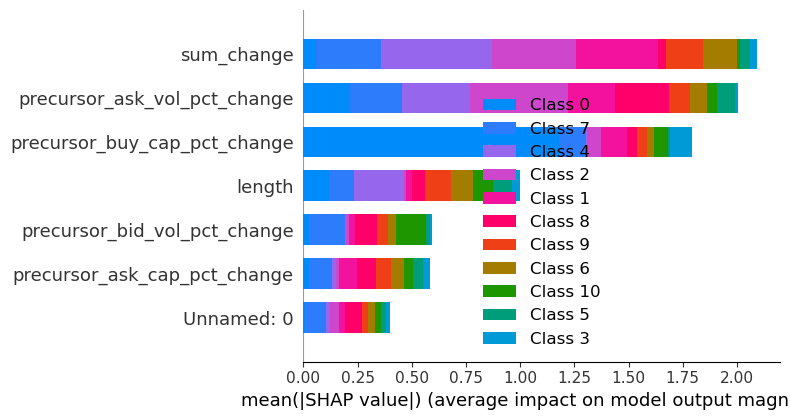

In [150]:
# estimators = [rfc,gbc,hgbc,etc,bc,vc]
model = hgbc.fit(X_train_scaled,y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, features=m2_pipeline.columns)

### Extra Trees Classifier SHAP

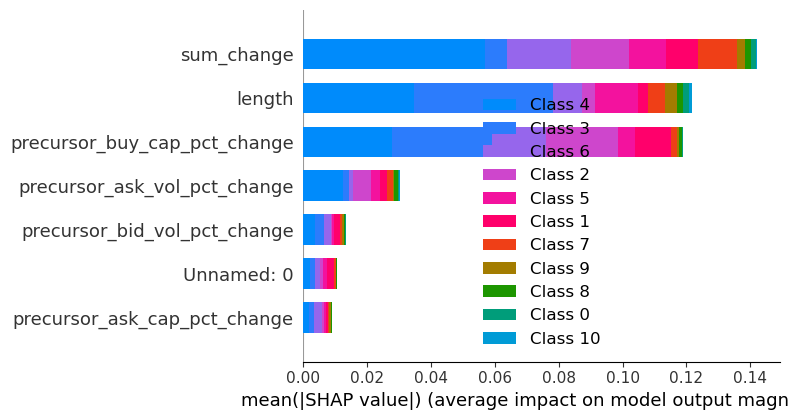

In [152]:
# estimators = [rfc,gbc,hgbc,etc,bc,vc]
model = etc.fit(X_train_scaled,y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, features=m2_pipeline.columns)

## 


### How do multiple classifiers collectively make good choices?

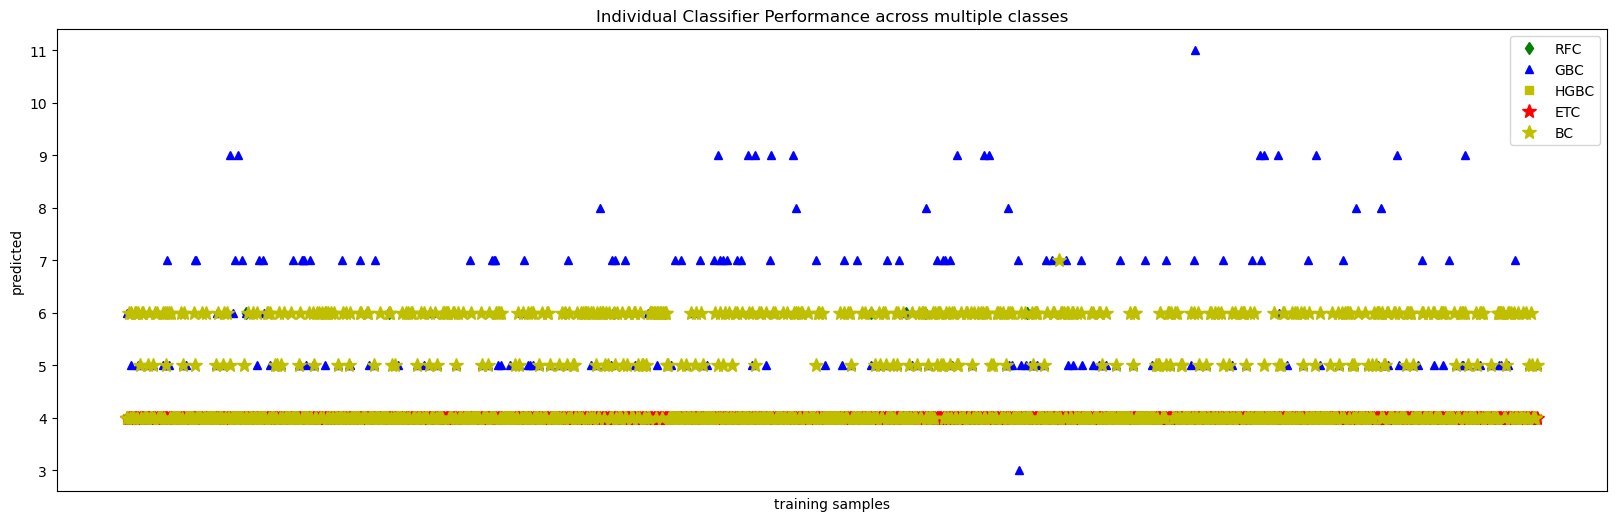

In [153]:
xt = X_test#  train_scaled[:300]

pred1 = rfc.predict(xt)
pred2 = gbc.predict(xt)
pred3 = hgbc.predict(xt)

pred4 = etc.predict(xt)
pred5 = bc.predict(xt)
pred6 = vc.predict(xt)

plt.figure(figsize=(20,6))
plt.plot(pred1, "gd", label="RFC")
plt.plot(pred2, "b^", label="GBC")
plt.plot(pred3, "ys", label="HGBC")
plt.plot(pred4, "r*", ms=10, label="ETC")
plt.plot(pred5, "y*", ms=10, label="BC")
# plt.plot(pred6, "g*", ms=10, label="VOTE")
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Individual Classifier Performance across multiple classes")
# ax.annotate('race interrupted', (61, 25),
#             xytext=(0.8, 0.9), textcoords='axes fraction',
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             fontsize=16,
#             horizontalalignment='right', verticalalignment='top')
plt.show()


### Can the voting classifier locate optimal trades among a sea of lesser options?

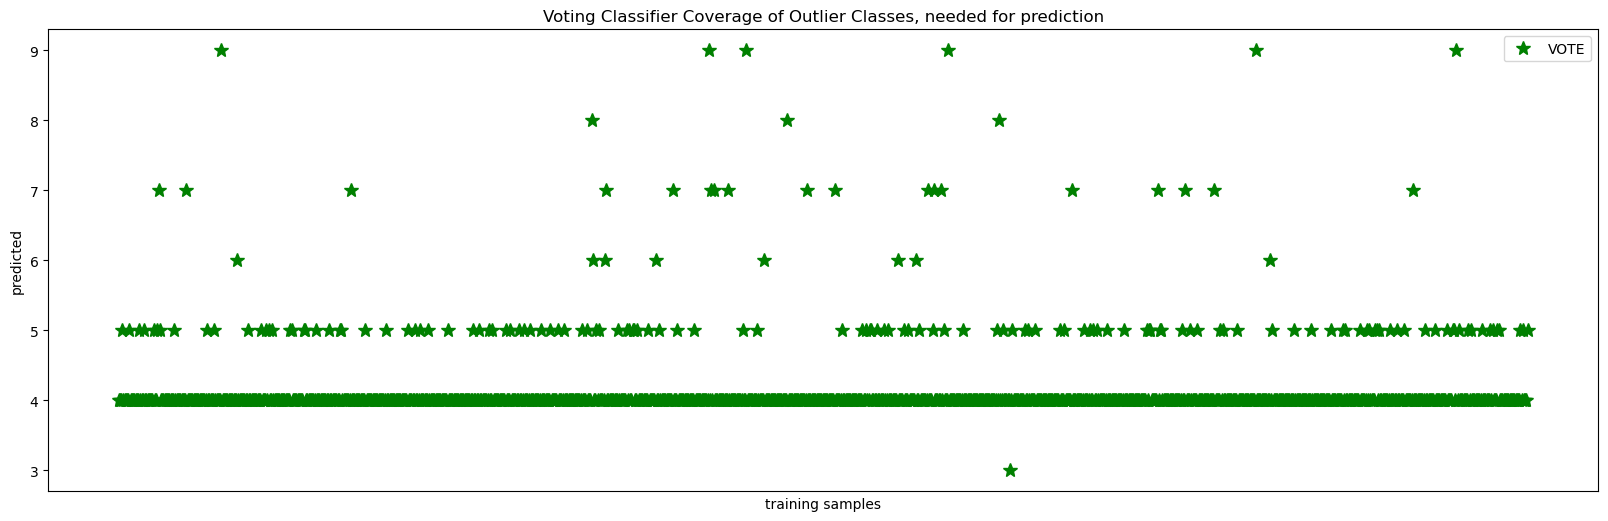

In [154]:
plt.figure(figsize=(20,6))
plt.plot(pred6, "g*", ms=10, label="VOTE")
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Voting Classifier Coverage of Outlier Classes, needed for prediction")
plt.show()

### GBC ability to identify outlier, profitable classes

              precision    recall  f1-score   support

           1       1.00      0.00      0.00         4
           2       1.00      0.00      0.00        22
           3       0.00      0.00      0.00        78
           4       0.45      0.81      0.58       511
           5       0.29      0.18      0.22       231
           6       0.06      0.01      0.01       139
           7       0.17      0.08      0.11       128
           8       0.17      0.03      0.05        34
           9       0.00      0.00      0.00         7
          10       1.00      0.00      0.00         9
          11       0.00      0.00      0.00         3

    accuracy                           0.40      1166
   macro avg       0.37      0.10      0.09      1166
weighted avg       0.31      0.40      0.31      1166



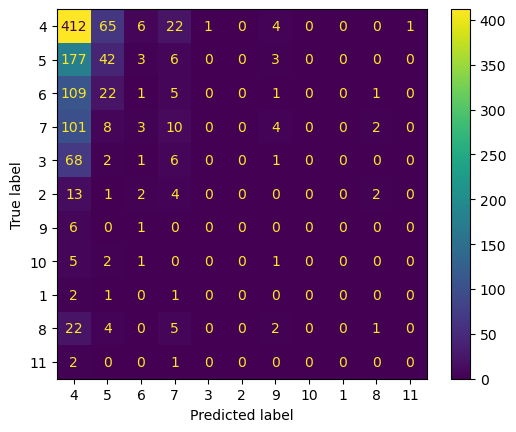

In [155]:
# X_test_scaled = scaler.fit_transform(X_test)
y_pred_gbc = gbc.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gbc, labels=labels_)

print(classification_report(y_test, y_pred_gbc,zero_division=1))


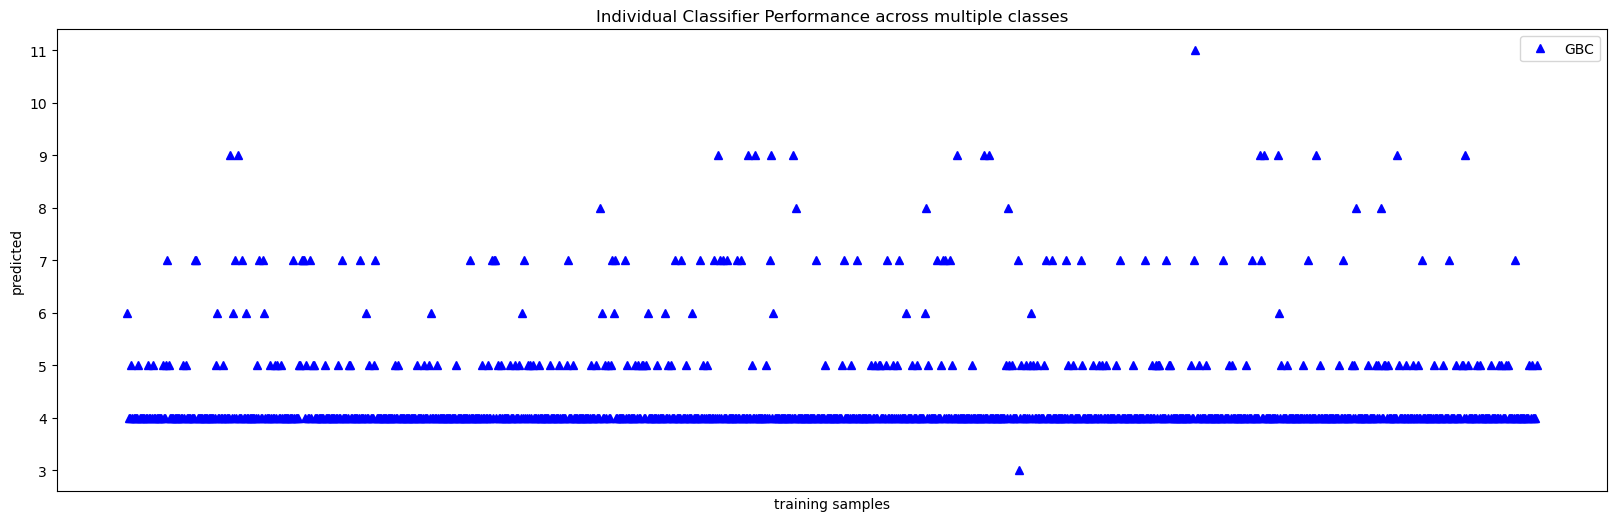

In [156]:
plt.figure(figsize=(20,6))
plt.plot(pred2, "b^", label="GBC")

# plt.plot(pred6, "g*", ms=10, label="VOTE")
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Individual Classifier Performance across multiple classes")
plt.show()


## create a time series from predicted values

In [157]:



# Predict labels for your test data
y_pred = gbc.predict(X_test)

X_test_df = pd.DataFrame(X_test)

# Concatenate the predicted labels with X_test_df
result = pd.concat([X_test_df, pd.Series(y_pred, name='predicted_label')], axis=1)

In [190]:
result['predicted_label'].value_counts()

4     917
5     147
7      60
6      18
9      16
8       6
11      1
3       1
Name: predicted_label, dtype: int64

In [171]:
print('\n'.join([f'{i}: {value}' for i, value in enumerate(keepable)]))

0: precursor_buy_cap_pct_change
1: precursor_ask_cap_pct_change
2: precursor_bid_vol_pct_change
3: precursor_ask_vol_pct_change
4: sum_change
5: length
6: time


In [173]:
result.dtypes

0                  float64
1                  float64
2                  float64
3                  float64
4                  float64
5                  float64
6                  float64
predicted_label      int64
dtype: object

In [177]:
# sns.pairplot(result, hue='predicted_label', height=1.5)
result = result.sort_values(by=6)

In [195]:
keepable = ['precursor_buy_cap_pct_change', 'precursor_ask_cap_pct_change',
            'precursor_bid_vol_pct_change', 'precursor_ask_vol_pct_change',
            'sum_change', 'length', 'time','predicted_label']

result = result.rename(columns={i: keepable[i] for i in range(7)})

In [197]:
result

,precursor_buy_cap_pct_change,precursor_ask_cap_pct_change,precursor_bid_vol_pct_change,precursor_ask_vol_pct_change,sum_change,length,surge_targets_met_pct,predicted_label
332,-0.008301,0.000101,-0.001793,0.015760,-0.008805,3.0,1.660232e+12,4
1093,0.251821,0.002041,0.076246,0.360129,-0.002041,1.0,1.660249e+12,7
234,-0.072644,0.000178,-0.022135,0.032534,-0.022106,4.0,1.660257e+12,4
301,0.066227,0.001243,0.022618,0.185320,-0.000311,1.0,1.660269e+12,7
952,-0.196120,-0.002084,-0.067795,-0.263773,-0.005565,2.0,1.660284e+12,6
...,...,...,...,...,...,...,...,...
1130,0.004096,0.000166,0.000969,0.000788,-0.000501,1.0,1.692974e+12,4
405,-0.003737,0.003281,-0.000869,0.016512,-0.005082,5.0,1.692990e+12,4
828,0.000449,-0.000605,0.000022,-0.003029,-0.000696,1.0,1.693045e+12,4
76,-0.008630,-0.000898,-0.002323,-0.003895,-0.001692,2.0,1.693064e+12,4


In [198]:
gds = pd.read_csv('global_data.csv')

In [199]:
# make a dataframe by joining gds on result, by time

# chart mp to time as a line  


# chart vertical lines for time and predicted_label


## why does GBC confuse class 10 as class 4?

In [77]:
m2_pipeline.columns

Index(['Unnamed: 0', 'precursor_buy_cap_pct_change',
       'precursor_ask_cap_pct_change', 'precursor_bid_vol_pct_change',
       'precursor_ask_vol_pct_change', 'sum_change', 'length',
       'surge_targets_met_pct', 'label'],
      dtype='object')

In [78]:
m2_pipeline.dtypes

Unnamed: 0                        int64
precursor_buy_cap_pct_change    float64
precursor_ask_cap_pct_change    float64
precursor_bid_vol_pct_change    float64
precursor_ask_vol_pct_change    float64
sum_change                      float64
length                            int64
surge_targets_met_pct           float64
label                             int64
dtype: object

In [87]:
# m2_pipeline[m2_pipeline['label'] == 4]

In [88]:
# Select rows with label equal to 4 or 10
# rows = m2_pipeline[(m2_pipeline['label'] == 4) | (m2_pipeline['label'] == 10)]
labeled = ['precursor_buy_cap_pct_change', 
            'precursor_ask_cap_pct_change',
            'precursor_bid_vol_pct_change', 
            'precursor_ask_vol_pct_change',
            'sum_change','length', 'label']
import pandas as pd
import matplotlib.pyplot as plt
subset = m2_pipeline[labeled]
subset.columns

Index(['precursor_buy_cap_pct_change', 'precursor_ask_cap_pct_change',
       'precursor_bid_vol_pct_change', 'precursor_ask_vol_pct_change',
       'sum_change', 'length', 'label'],
      dtype='object')

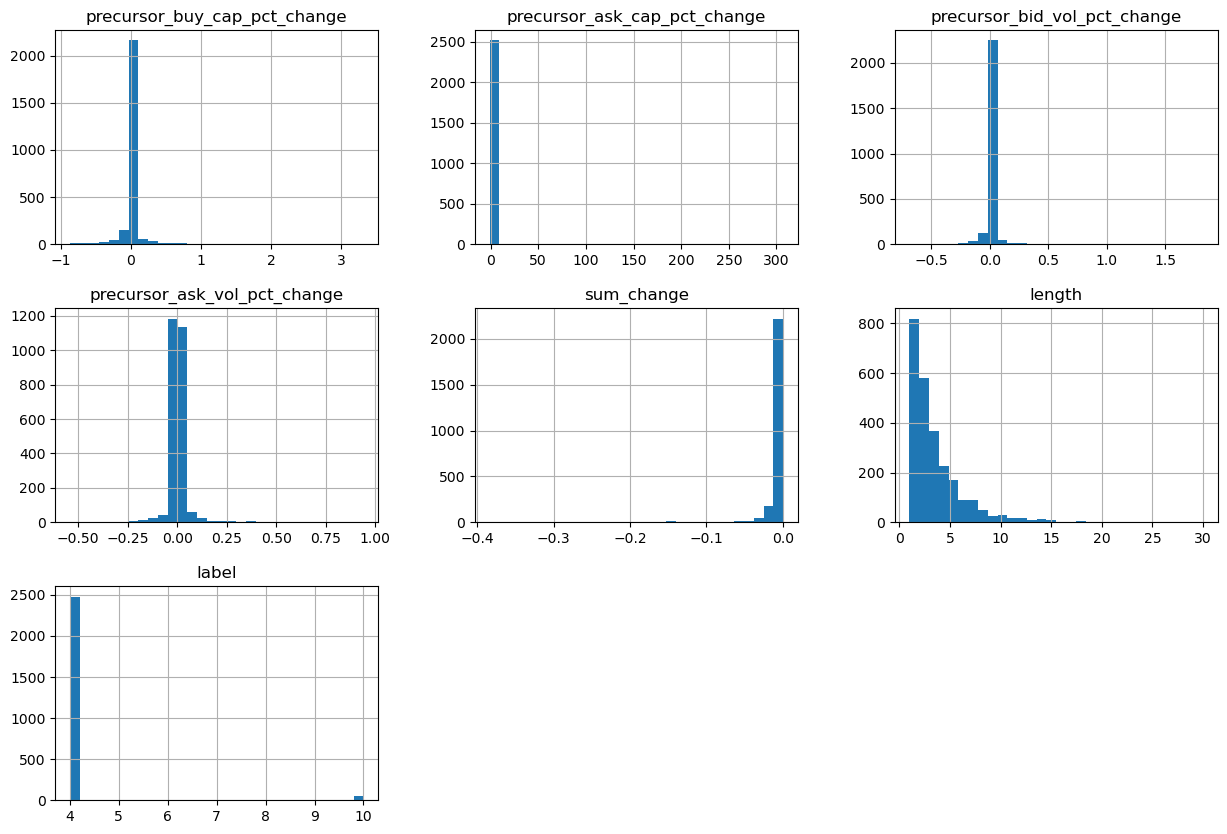

In [95]:
# Select rows with label equal to 4 or 10
rows = subset[(subset['label'] == 4) | (subset['label'] == 10)]

# Create histograms for all columns in the selected rows
rows.hist(bins=30, figsize=(15, 10))

# Show the histograms
plt.show()

In [96]:
subset[(subset['label'] == 4)]['sum_change'].mean()

-0.008453832723064823

In [97]:
subset[(subset['label'] == 10)]['sum_change'].mean()

-0.03706188073835746

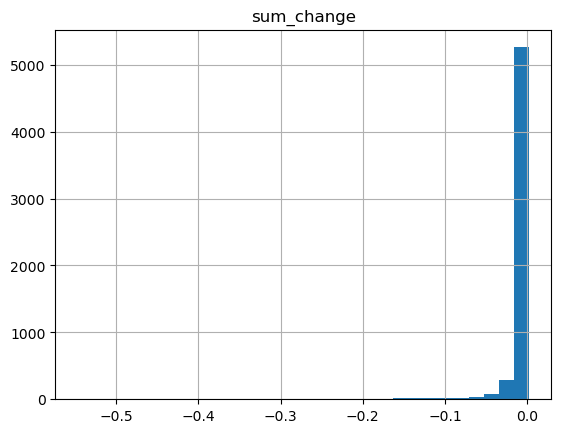

In [98]:
# Create a histogram for the 'sum_change' column
subset.hist(column='sum_change', bins=30)

# Show the histogram
plt.show()

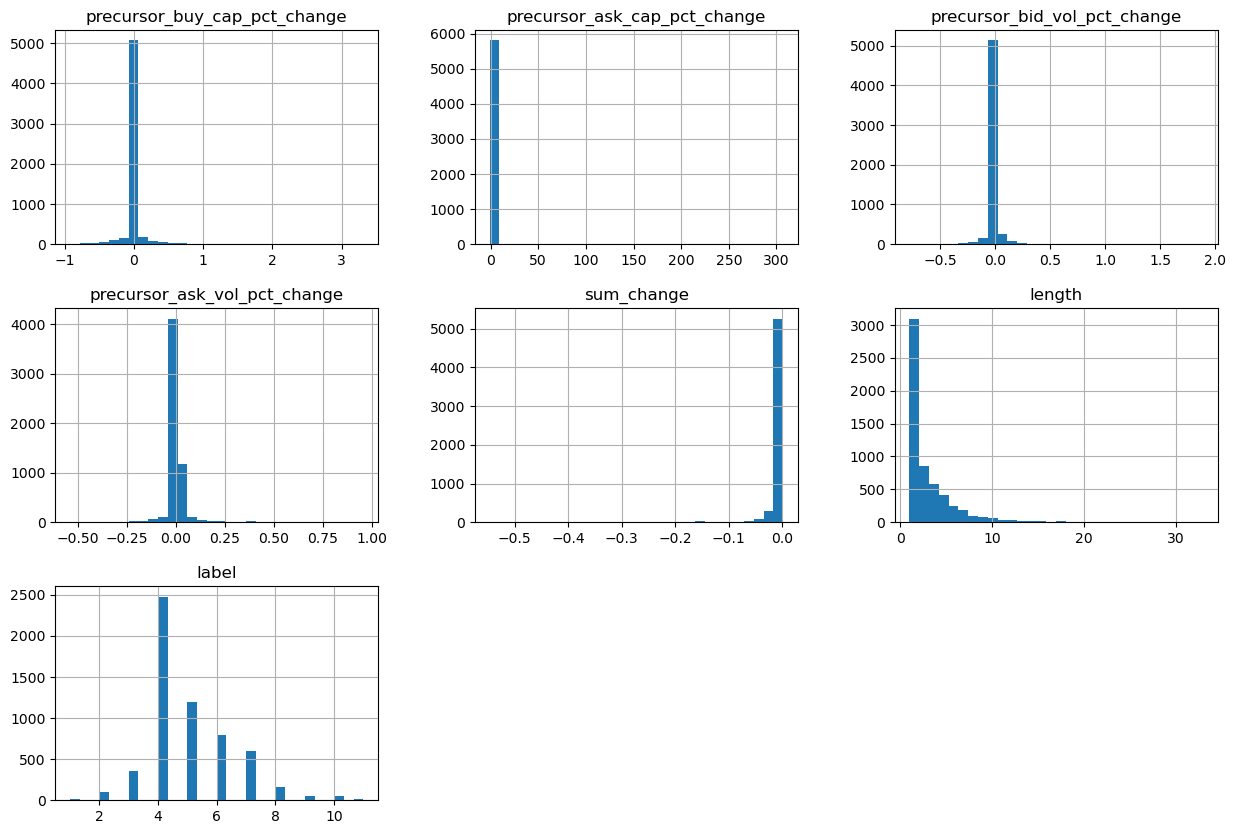

In [99]:
subset.hist(bins=30, figsize=(15, 10))

# Show the histograms
plt.show()

### distribution of features, class 10

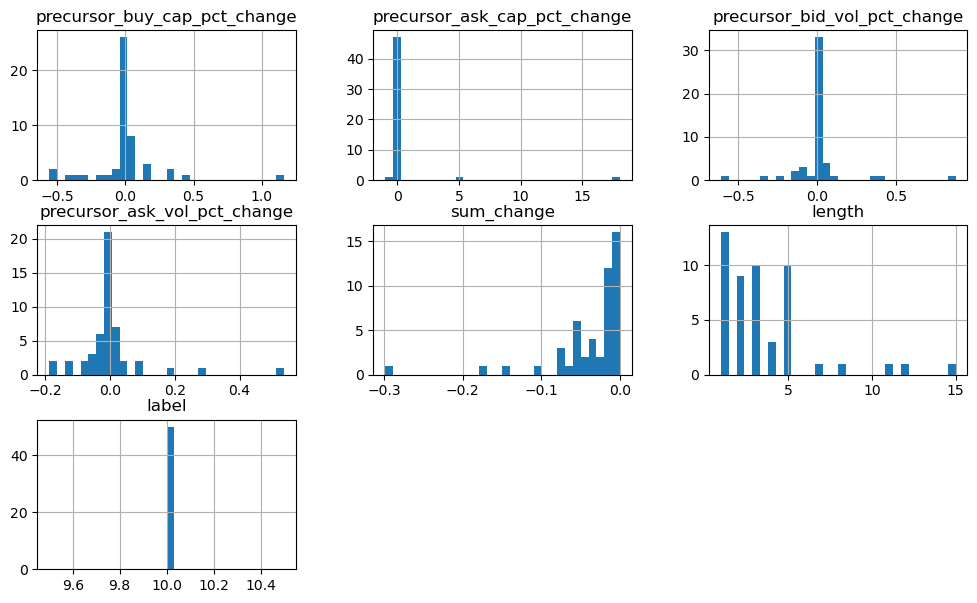

In [111]:
subset[(subset['label'] == 10)].hist(bins=30, figsize=(12, 7))
plt.show()

### feature distribution, class 4

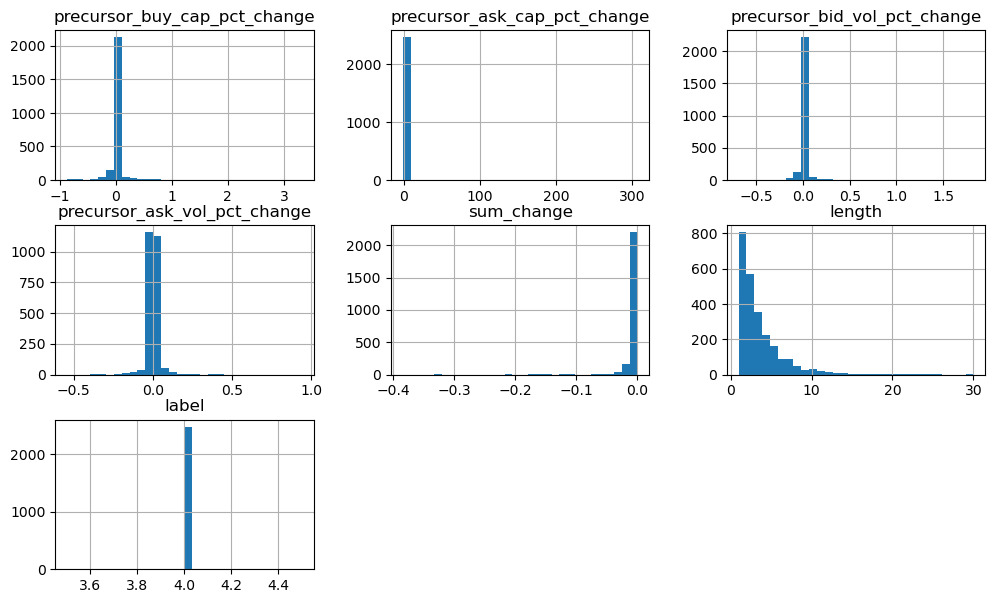

In [112]:
subset[(subset['label'] == 4)].hist(bins=30, figsize=(12, 7))
plt.show()

## Permutation test scoring

[from sklearn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_permutation_tests_for_classification.html#permutation-test-score)

## managing class imbalance

(https://stackoverflow.com/a/55591245)

see next sheet, 5.1


In [ ]:
#save this thing to .pkl format

# import pickle

# with open("model.pkl", "wb") as f:
#     pickle.dump(vc, f)